# Import Modules and Data

In [4]:
from glob import glob
import geopandas as gp
import numpy as np
import pandas as pd
import pickle
import random
from copy import deepcopy
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier
from sklearn.model_selection import ParameterGrid

import warnings
warnings.filterwarnings("ignore")

import os

os.chdir('/server-root/Krishna/mncfc_crop_classification/')

In [6]:
pwd

'/server-root/Krishna/mncfc_crop_classification'

In [5]:
train = pd.read_csv(r'data_files\data_share\train-3.csv')
test = pd.read_csv(r'data_files\data_share\test-3.csv')
val = pd.read_csv(r'data_files\data_share\val-3.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'data_files\\data_share\\train-3.csv'

# Seeding

In [5]:
def seed_everything(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    
seed_everything()

# Predictor and label split

In [6]:
X_train = train.drop('crop_name', axis=1)
y_train = train['crop_name']

X_val = val.drop('crop_name', axis=1)
y_val = val['crop_name']

X_test = test.drop('crop_name', axis=1)
y_test = test['crop_name']

## Scaling

In [7]:
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# pickle.dump(scaler, open(r'models/XGB_Binary_sowing-nov1f_StandardScaler_1.1', 'wb'))

## Modelling

- Labels =  1 : 'Wheat_nov_1f, 0 : Non-Wheat
- FP = GT is non wheat but model predicted wheat
- FN = GT is wheat but model predicted non wheat

- Will be training my model on the recall score of non wheat class

In [8]:
fort_nights = list(X_train.loc[:, 'oct_2f':'apr_1f'].columns)

params = {'n_estimators':np.arange(5,100,5), 'learning_rate':np.arange(0.05, 0.55, 0.05), 
          'max_depth':np.arange(1,5,1)}

# sample_weights = compute_sample_weight(class_weight='balanced',y=y_train)

param_grid = list(ParameterGrid(params))
max_recall_scores = []
fns_used = []

i = 0

while (i + 4) <= len(fort_nights):
    recall_scores = []
    if i == 0:
        drop_cols = []
    else:
        drop_cols = fort_nights[-i:]
    for p in param_grid:
        wheat_classifier = XGBClassifier(**p)
        temp_X_train = X_train.drop(drop_cols, axis=1)
        temp_X_val = X_val.drop(drop_cols, axis=1)
        wheat_classifier.fit(temp_X_train, y_train)
        val_pred = wheat_classifier.predict(temp_X_val)
        precision, recall, f1score, support = score(y_val, val_pred, labels=[0,1])
        recall_scores.append(recall)
        
    recall_scores = pd.DataFrame(recall_scores)
    # Max Non_wheat recall where Wheat recall is atleast 0.79
    try:
        max_nw_idx = recall_scores[recall_scores.iloc[:,1]>0.79].idxmax(axis=0)[0]
        max_nw_scores = recall_scores.loc[max_nw_idx,:].values
        max_recall_scores.append([max_nw_scores, param_grid[max_nw_idx]])

        fns_used.append('-'.join(temp_X_train.columns[[0,-1]]))
        print(len(drop_cols), 'dropped', 'completed')
    except:
        print(f'Wheat Recall is less than 0.79 if {drop_cols} are dropped')
    
    i += 1
    
print('Done!!')

0 dropped completed
1 dropped completed
2 dropped completed
3 dropped completed
4 dropped completed
5 dropped completed
6 dropped completed
7 dropped completed
8 dropped completed
Done!!


In [9]:
max_recall_scores

[[array([0.99596774, 0.98519737]),
  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 75}],
 [array([0.99596774, 0.98519737]),
  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 65}],
 [array([0.99596774, 0.98355263]),
  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 65}],
 [array([0.99596774, 0.98848684]),
  {'learning_rate': 0.15000000000000002, 'max_depth': 3, 'n_estimators': 60}],
 [array([0.99193548, 0.98519737]),
  {'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 25}],
 [array([0.99193548, 0.98519737]),
  {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 80}],
 [array([0.98790323, 0.98684211]),
  {'learning_rate': 0.4, 'max_depth': 3, 'n_estimators': 90}],
 [array([0.97580645, 0.97532895]),
  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 90}],
 [array([0.96774194, 0.98026316]),
  {'learning_rate': 0.35000000000000003, 'max_depth': 4, 'n_estimators': 65}]]

In [10]:
test_recall_scores = []
confusion_matrices = []
test_dfs = []
best_models = []

for i in range(len(fns_used)):
    best_classifier = XGBClassifier(**max_recall_scores[i][1])
    
    strt_fn, end_fn = fns_used[i].split('-') 
    temp_X_train = X_train.loc[:, strt_fn:end_fn]
    temp_X_test = X_test.loc[:, strt_fn:end_fn]
    best_classifier.fit(temp_X_train, y_train)
    best_models.append(best_classifier)
#     pickle.dump(best_classifier, open(r'models/XGB_Binary_sowing-nov1f_{}_1.1'.format('-'.join(temp_X_train.columns[[0,-1]])), 'wb'))
    test_pred = best_classifier.predict(temp_X_test)
    precision, recall, f1score, support = score(y_test, test_pred, labels=[0,1])
    test_recall_scores.append([round(recall[0], 2), round(recall[1], 2)])
    cf = pd.crosstab(y_test, pd.Series(test_pred, name='pred')).rename({0:'Non_wheat', 1:'Wheat'}).rename({0:'Non_wheat', 1:'Wheat'}, axis=1)
    confusion_matrices.append(cf)
    df1 = pd.DataFrame(data = {'GT':confusion_matrices[-1].sum(axis=1),
                                    'correct_pred':np.diag(confusion_matrices[-1])})
    df1['correct_pred(%)'] = round(df1['correct_pred']/df1['GT']*100, 2)
    temp_df = deepcopy(confusion_matrices[-1])
    np.fill_diagonal(temp_df.values, 0)
    temp_df.columns = ['incorr_pred_nw', 'incorrect_pred_wh']
    df1 = pd.concat([df1, temp_df], axis=1)
    test_dfs.append(df1)
    
test_scores = pd.DataFrame({'Fortnites Used':fns_used, 'Mustard':np.array(test_recall_scores)[:,0], 'Wheat':np.array(test_recall_scores)[:,1]})
test_scores

,Fortnites Used,Mustard,Wheat
0,oct_2f-apr_1f,1.00,0.88
1,oct_2f-mar_2f,1.00,0.85
2,oct_2f-mar_1f,1.00,0.89
3,oct_2f-feb_2f,0.99,0.96
4,oct_2f-feb_1f,0.99,0.97
5,oct_2f-jan_2f,0.99,0.97
6,oct_2f-jan_1f,0.99,0.96
7,oct_2f-dec_2f,1.00,0.94
8,oct_2f-dec_1f,0.99,0.87


In [11]:
oct_apr = XGBClassifier(**max_recall_scores[0][1])
oct_apr.fit(X_train, y_train)
fi = pd.DataFrame({'Feature':X_train.columns, 'Feature Imp':oct_apr.feature_importances_})
fi

,Feature,Feature Imp
0,oct_2f,0.035046
1,nov_1f,0.012383
2,nov_2f,0.495513
3,dec_1f,0.159821
4,dec_2f,0.016651
5,jan_1f,0.075128
6,jan_2f,0.039096
7,feb_1f,0.070197
8,feb_2f,0.029685
9,mar_1f,0.039186


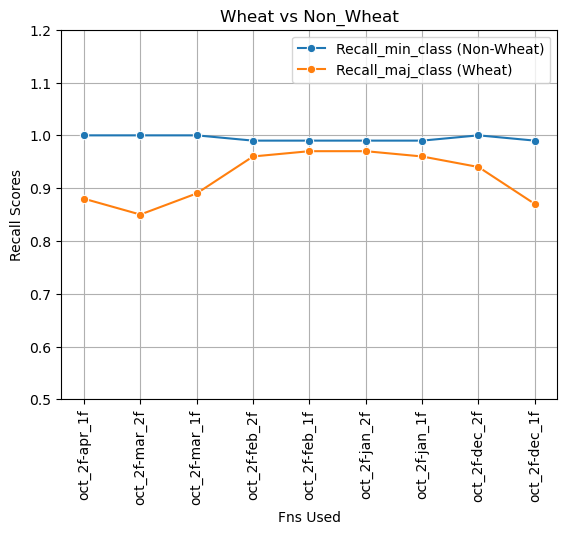

In [12]:
sns.lineplot(y=np.array(test_recall_scores)[:,0], x=fns_used, label='Recall_min_class (Non-Wheat)', marker="o")
sns.lineplot(y=np.array(test_recall_scores)[:,1], x=fns_used, label='Recall_maj_class (Wheat)', marker="o")
plt.xlabel('Fns Used')
plt.ylabel('Recall Scores')
plt.xticks(rotation='vertical')
plt.title('Wheat vs Non_Wheat')
plt.ylim([0.5,1.2])
plt.grid()
plt.show()

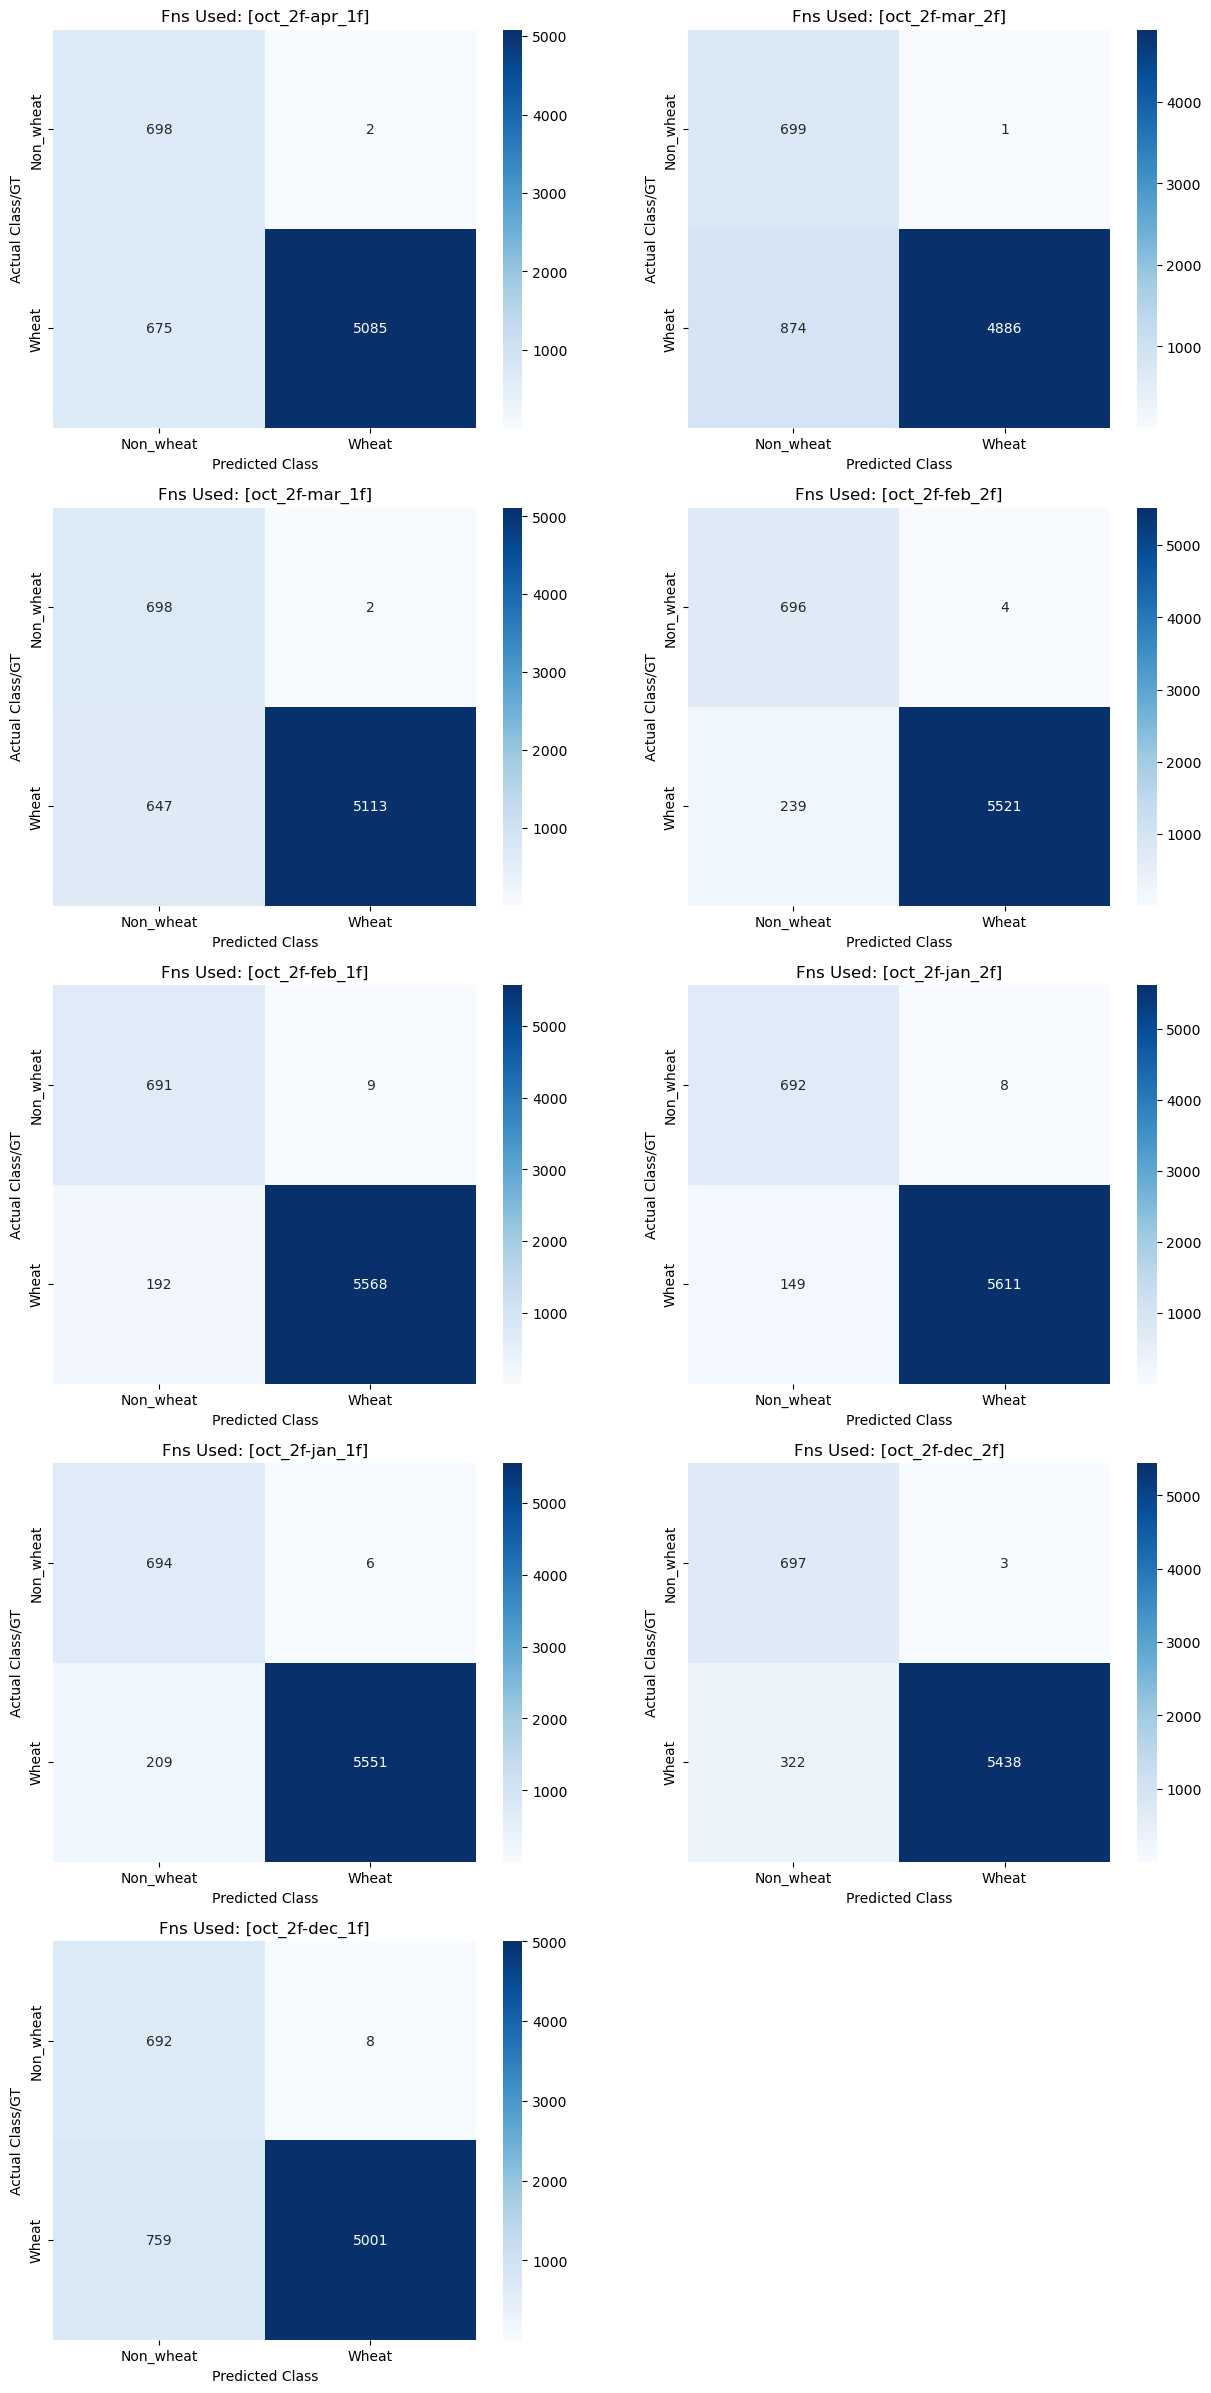

In [13]:
plt.figure(figsize=(15,30))

for i in range(len(confusion_matrices)):
    plt.subplot(5,2,i+1)
    sns.heatmap(confusion_matrices[i], annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class/GT')
    plt.title(f'Fns Used: [{fns_used[i]}]')
plt.show()

# Predicting Unlabelled data using the best model

In [14]:
best_model_dict = {}

for i in range(len(fns_used)):
    best_model_dict[fns_used[i]] = best_models[i]

In [15]:
unlabelled = pd.read_csv(r'data_files/data_share/cleaned_others.csv')

unlabelled.head(3)

# Scaling
scaled_unlabelled = pd.DataFrame(data = scaler.transform(unlabelled), columns = unlabelled.columns)

In [38]:
# our best_model was built with NDVI bands from oct_2f to jan_2f
strt_fn, end_fn = 'oct_2f', 'jan_2f'
threshold = 0.95

reduced_unlabelled = scaled_unlabelled.loc[:, strt_fn:end_fn]

unlabelled_pred_proba = best_model_dict[strt_fn+'-'+end_fn].predict_proba(reduced_unlabelled).round(2)
unlabelled_pred = best_model_dict[strt_fn+'-'+end_fn].predict(reduced_unlabelled)

max_prob = unlabelled_pred_proba.max(axis=1)

df = pd.DataFrame(unlabelled_pred_proba, index=unlabelled.index, columns=['Mustard', 'Wheat'])
df['pred'] = unlabelled_pred
df['pred'] = df['pred'].apply(lambda lab: 'Mustard' if lab == 0 else 'Wheat')
df[f'{threshold}'] = (max_prob >= threshold)

display(df[df[f'{threshold}'] == True].shape, df.shape, df['pred'].value_counts())

(8384, 4)

(11677, 4)

Wheat      6279
Mustard    5398
Name: pred, dtype: int64

In [40]:
pd.concat([unlabelled, df[['Mustard', 'Wheat', 'pred']]], axis=1).to_csv(r'data_files\data_share\predicted_others.csv', index=False)

,0,1,pred,0.95
5962,0.926711,0.073289,0,False
10008,0.731411,0.268589,0,False
4154,0.644973,0.355027,0,False
3360,0.694665,0.305335,0,False
1145,0.865932,0.134068,0,False
743,0.837057,0.162943,0,False
3280,0.819415,0.180585,0,False
75,0.698249,0.301751,0,False
495,0.948906,0.051094,0,False
6215,0.635781,0.364219,0,False


<Axes: >

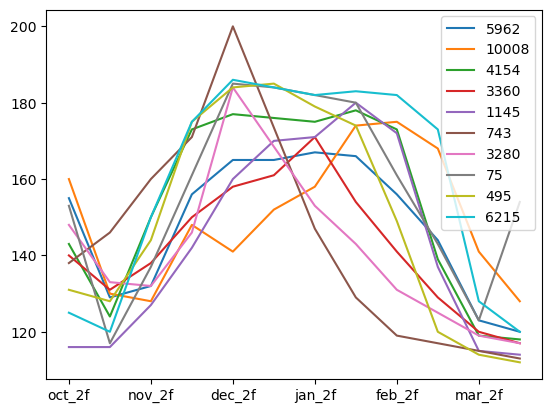

In [165]:
display(df[(df[f'{threshold}'] == False) & (df['pred'] == 0)].sample(10, random_state=50))

unlabelled.loc[df[(df[f'{threshold}'] == False) & (df['pred'] == 0)].index].sample(10, random_state=50).T.plot()

,0,1,pred,0.95
3463,0.250783,0.749217,1,False
1806,0.308386,0.691614,1,False
8304,0.185526,0.814474,1,False
5774,0.448553,0.551447,1,False
1564,0.065028,0.934972,1,False
7190,0.050389,0.949611,1,False
6068,0.068432,0.931568,1,False
6146,0.313604,0.686396,1,False
11649,0.179598,0.820402,1,False
4418,0.229124,0.770876,1,False


<Axes: >

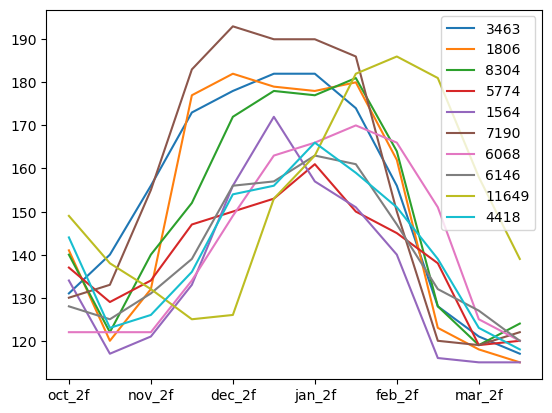

In [167]:
display(df[(df[f'{threshold}'] == False) & (df['pred'] == 1)].sample(10, random_state=150))

unlabelled.loc[df[(df[f'{threshold}'] == False) & (df['pred'] == 1)].index].sample(10, random_state=150).T.plot()

<Axes: >

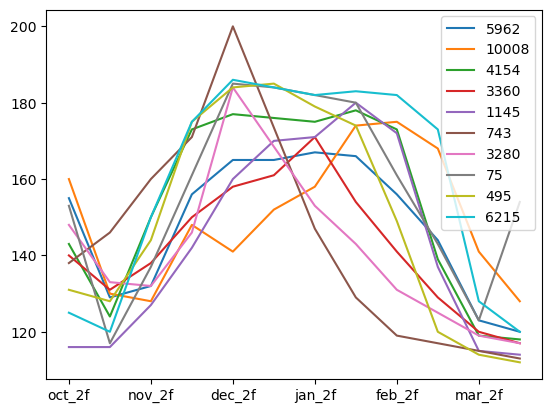

In [168]:
unlabelled.loc[df[(df[f'{threshold}'] == False) & (df['pred'] == 0)].index].sample(10, random_state=50).T.plot()

# Rough Work

In [28]:
pd.Series(oct_apr.predict(X_test)).value_counts()

1    5087
0    1373
dtype: int64

In [26]:
pd.DataFrame(oct_apr.predict_proba(X_test)).describe()

,0,1
count,6460.000000,6460.000000
mean,0.196172,0.803828
std,0.347126,0.347127
min,0.000886,0.002428
25%,0.001502,0.771980
50%,0.002275,0.997725
75%,0.228020,0.998498
max,0.997572,0.999114


In [43]:
y_test.value_counts()

1    5760
0     700
Name: crop_name, dtype: int64

In [47]:
max_prob = oct_apr.predict_proba(X_test).max(axis=1)
df = pd.DataFrame(oct_apr.predict_proba(X_test))
df['pred'] = oct_apr.predict(X_test)
df['GT'] = y_test
df['0.5-0.7'] = (max_prob >= 0.5) & (max_prob <= 0.7)
df['0.9-0.1'] = (max_prob >= 0.9) & (max_prob <= 1)
# df[(df['0.9-0.1'] == True) & (df.pred == 0)]
df[(df.GT == 1) & (df.pred == 0)]

,0,1,pred,GT,0.5-0.7,0.9-0.1
268,0.760647,0.239353,0,1,False,False
345,0.708431,0.291569,0,1,False,False
373,0.705803,0.294197,0,1,False,False
868,0.681252,0.318748,0,1,True,False
1036,0.571451,0.428549,0,1,True,False
...,...,...,...,...,...,...
5717,0.986659,0.013341,0,1,False,True
5722,0.637167,0.362833,0,1,True,False
5731,0.758443,0.241557,0,1,False,False
5735,0.510395,0.489605,0,1,True,False


In [66]:
df[(df['0.5-0.7'] == True) & (df['GT'] == 0)]

,0,1,pred,GT,0.5-0.7,0.9-0.1
5950,0.692932,0.307068,0,0,True,False
6097,0.451104,0.548896,1,0,True,False
6336,0.650211,0.349789,0,0,True,False
6380,0.449329,0.550671,1,0,True,False
6431,0.561830,0.438170,0,0,True,False


,oct_2f,nov_1f,nov_2f,dec_1f,dec_2f,jan_1f,jan_2f,feb_1f,feb_2f,mar_1f,mar_2f,apr_1f
5950,132.0,128.0,150.0,183.0,185.0,186.0,182.0,176.0,166.0,145.0,122.0,120.0
6336,124.0,132.0,152.0,156.0,149.0,147.0,200.0,143.0,125.0,121.0,121.0,121.0
6431,126.0,132.0,152.0,177.0,183.0,183.0,181.0,178.0,155.0,144.0,121.0,117.0


<Axes: >

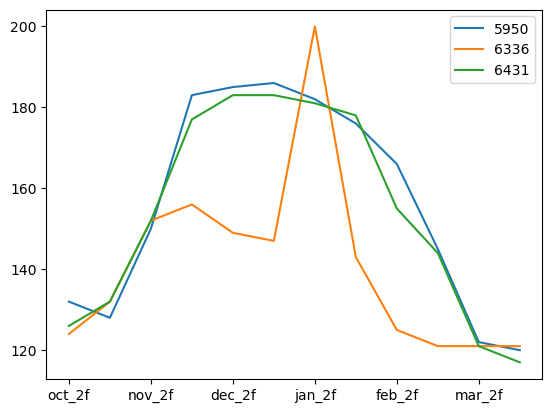

In [68]:
display(test.loc[df[(df['0.5-0.7'] == True) & (df['GT'] == 0)& (df['pred'] == 0)].index, :'apr_1f'])
test.loc[df[(df['0.5-0.7'] == True) & (df['GT'] == 0) & (df['pred'] == 0)].index, :'apr_1f'].T.plot()

In [73]:
test.loc[df[(df['0.5-0.7'] == True) & (df['GT'] == 1)& (df['pred'] == 1)].index, :'apr_1f']

,oct_2f,nov_1f,nov_2f,dec_1f,dec_2f,jan_1f,jan_2f,feb_1f,feb_2f,mar_1f,mar_2f,apr_1f
230,171.0,140.0,125.0,124.0,133.0,143.0,151.0,172.0,175.0,174.0,162.0,136.0
231,169.0,141.0,126.0,127.0,133.0,145.0,150.0,172.0,174.0,171.0,161.0,135.0
277,157.0,145.0,130.0,164.0,179.0,183.0,184.0,189.0,187.0,180.0,145.0,122.0
511,173.0,153.0,132.0,130.0,142.0,157.0,159.0,170.0,173.0,169.0,152.0,130.0
744,166.0,144.0,123.0,124.0,123.0,134.0,144.0,167.0,172.0,174.0,163.0,134.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5338,139.0,128.0,152.0,177.0,193.0,195.0,194.0,189.0,175.0,159.0,123.0,118.0
5350,140.0,130.0,136.0,167.0,188.0,195.0,194.0,189.0,184.0,182.0,152.0,127.0
5679,148.0,133.0,136.0,167.0,187.0,190.0,187.0,188.0,179.0,175.0,139.0,124.0
5701,155.0,135.0,136.0,171.0,188.0,193.0,190.0,188.0,187.0,176.0,133.0,121.0


In [86]:
test.loc[df[(df['GT'] == 1) & (df['pred'] == 0)].index, :'apr_1f'].sample(10, random_state=4)

,oct_2f,nov_1f,nov_2f,dec_1f,dec_2f,jan_1f,jan_2f,feb_1f,feb_2f,mar_1f,mar_2f,apr_1f
3723,150.0,124.0,140.0,161.0,184.0,187.0,192.0,191.0,193.0,179.0,142.0,126.0
3984,139.0,137.0,170.0,186.0,191.0,192.0,190.0,185.0,178.0,158.0,126.0,123.0
3540,151.0,128.0,137.0,164.0,184.0,188.0,188.0,188.0,189.0,184.0,145.0,126.0
1490,131.0,130.0,152.0,180.0,197.0,192.0,189.0,189.0,176.0,167.0,128.0,120.0
1485,152.0,134.0,142.0,164.0,190.0,189.0,187.0,190.0,187.0,177.0,148.0,125.0
3521,155.0,125.0,155.0,178.0,188.0,193.0,191.0,196.0,193.0,178.0,134.0,122.0
1340,136.0,131.0,153.0,178.0,198.0,194.0,189.0,190.0,179.0,177.0,133.0,119.0
5050,158.0,133.0,139.0,164.0,187.0,192.0,190.0,192.0,193.0,175.0,138.0,125.0
3805,137.0,126.0,147.0,172.0,183.0,186.0,197.0,190.0,188.0,175.0,138.0,126.0
3561,139.0,128.0,159.0,178.0,187.0,191.0,199.0,193.0,187.0,175.0,128.0,121.0


In [84]:
df.loc[[3723, 3984, 3540, 1490, 1485, 3521, 1340, 5050, 3805, 3561]]

,0,1,pred,GT,0.5-0.7,0.9-0.1
3723,0.639006,0.360994,0,1,True,False
3984,0.985709,0.014291,0,1,False,True
3540,0.700566,0.299434,0,1,False,False
1490,0.698520,0.301480,0,1,True,False
1485,0.550717,0.449283,0,1,True,False
3521,0.502417,0.497583,0,1,True,False
1340,0.568013,0.431987,0,1,True,False
5050,0.560546,0.439454,0,1,True,False
3805,0.780814,0.219186,0,1,False,False
3561,0.530372,0.469628,0,1,True,False


In [1]:
test.loc[df[(df['GT'] == 1) & (df['pred'] == 0)].index, :'apr_1f'].sample(10, random_state=4).T.plot()

NameError: name 'test' is not defined

,0,1,pred,GT,0.5-0.7,0.9-0.1
3479,0.453895,0.546105,1,1,True,False
3917,0.395934,0.604066,1,1,True,False
1579,0.483808,0.516192,1,1,True,False
3627,0.459809,0.540191,1,1,True,False
4307,0.486149,0.513851,1,1,True,False
3524,0.423478,0.576522,1,1,True,False
1309,0.319135,0.680865,1,1,True,False
5166,0.482411,0.517589,1,1,True,False
4107,0.404147,0.595853,1,1,True,False
912,0.457377,0.542623,1,1,True,False


<Axes: >

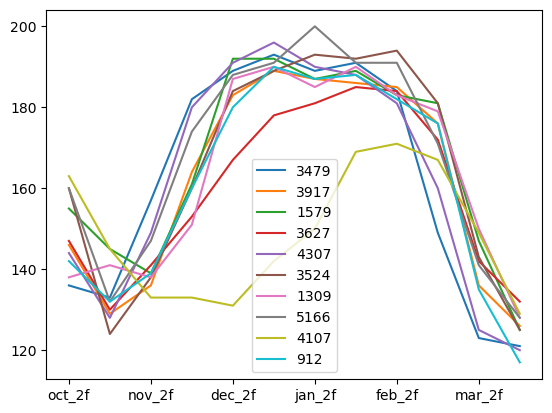

In [72]:
display(df[(df['0.5-0.7'] == True) & (df['GT'] == 1)& (df['pred'] == 1)].sample(10, random_state=0))

test.loc[df[(df['0.5-0.7'] == True) & (df['GT'] == 1)& (df['pred'] == 1)].index, :'apr_1f'].sample(10, random_state=0).T.plot()


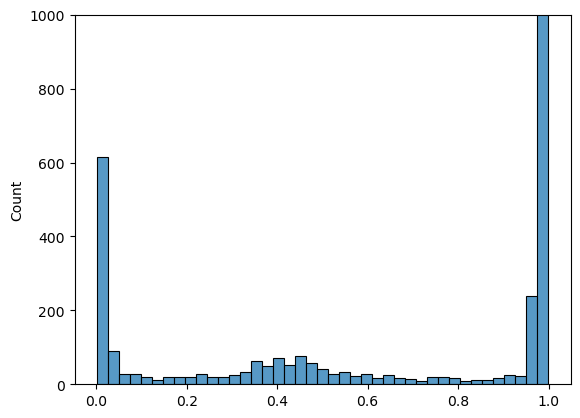

In [31]:
sns.histplot(oct_apr.predict_proba(X_test)[:,1])
plt.ylim((0,1000))
plt.show()